# Casting process assignment (Metal Defect Classifier - 99.30 % accuracy)
With the help of this matel defect data set we have build a deep learning model with a accuracy of **99.30%** which will help to classifiy images as defective or okay. It will reduce error in the quality inspection and hence will save money as well as time. 

## importing Libraries

In [77]:
import glob
import cv2
import os
import keras as ks
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
%matplotlib inline

## Function to show image

In [3]:
def show_image(path):
    img = cv2.imread(dir,0)
    img = [x[25:-25] for x in img][25:-25]
    print('Image Shape : ',len(img),len(img[0]))
    plt.figure(figsize=(5,5))
    plt.title('Image')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.imshow(img,'gray')

## Exploratory Data Analysis
Displaying an example image

(300, 300)


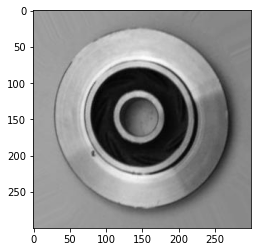

In [29]:
image = "archive/casting_data/casting_data/train/def_front/cast_def_0_0.jpeg"
get_image(image)

We have created a 3x3 subplot and Displaying some of the defected material images. We noticed that we are reading the images that are a bit zoom out. Hence taking into consideration a lot of unnecessay data.

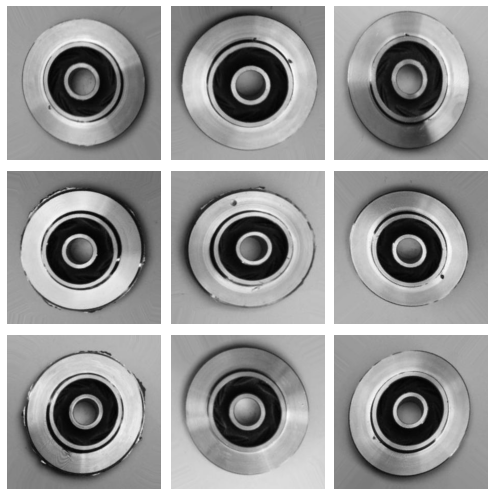

In [30]:
lst=glob.glob("archive/casting_data/casting_data/train/def_front/*.jpeg")

plt.figure(figsize=(7, 7))
i=1
for dir in lst[:9]:
    plt.subplot(3, 3, i)
    image = cv2.imread(dir)
    plt.axis("off")
    plt.imshow(image,cmap='gray')
    i+=1
plt.tight_layout()    
plt.show()

So we preprocessed the image and converted it into 250x250 from 300x300. Hence we will be processing only usefull data which results in saving time as well as incresing model accuracy.

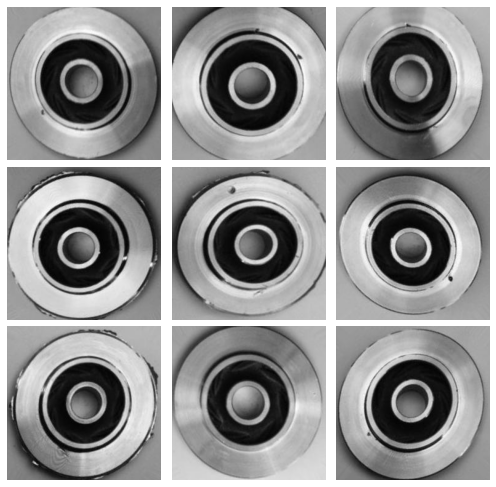

In [31]:
plt.figure(figsize=(7, 7))
i=1
for dir in lst[:9]:
    plt.subplot(3, 3, i)
    plt.tight_layout()
    image = cv2.imread(dir)
    image = [x[25:-25] for x in image][25:-25]
    plt.axis("off")
    plt.imshow(image,cmap='gray')
    i+=1
plt.tight_layout()   
plt.show()

## Zooming function

We have created a function which will takes images directory path and create new zoom out images.

In [ ]:
def zooming_func(path):
    for dir in path:
        img = cv2.imread(dir,0)
        img = np.array([x[25:-25] for x in img][25:-25], dtype=np.uint8)
        # Use PIL to create an image from the new array of pixels
        new_image = Image.fromarray(img)
        cv2.imwrite('new_'+dir,img)

## Generating Zoom in data

In [ ]:
train_ok = glob.glob("archive/casting_data/casting_data/train/ok_front/*.jpeg")
zooming_func(train_ok)

test_ok = glob.glob("archive/casting_data/casting_data/test/ok_front/*.jpeg")
zooming_func(test_ok)

train_def = glob.glob("archive/casting_data/casting_data/train/def_front/*.jpeg")
zooming_func(train_def)

test_def = glob.glob("archive/casting_data/casting_data/test/def_front/*.jpeg")
zooming_func(train_def)

## Create Image Data Generator

We are using Keras ImageDataGenerator to create Image augmentation. Image augmentation is a technique of applying different transformations to original images which results in multiple transformed copies of the same image. Each copy, however, is different from the other in certain aspects depending on the augmentation techniques you apply like shifting, rotating, flipping, etc. Applying these small amounts of variations on the original image does not change its target class but only provides a new perspective of capturing the object in real life. And so, we use it is quite often for building deep learning models.

For augmentation we will be using 
* image rescale
* shear range transformation
* random rotation
* Random brightness change
* Random horizontal and vertical flip

In [6]:
def datapreprocessing(main_dir,bsize):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    train_gen = ImageDataGenerator(rescale=1.0/255,
                                   shear_range=0.2,
                                   fill_mode='nearest',
                                   rotation_range=90,
                                   brightness_range=[0.4,1.5],
                                   horizontal_flip=True, vertical_flip=True
                                  )

    train_generator = train_gen.flow_from_directory(
        directory=main_dir,
        target_size=(250,250),
        batch_size=bsize,
        color_mode="grayscale",
        shuffle=True,
        subset="training",
        class_mode='binary')
    
    return train_generator

In [2]:
train_dir = "new_archive/casting_data/casting_data/train/"
test_dir = "new_archive/casting_data/casting_data/test/"

In [7]:
traingen = datapreprocessing(train_dir,20)
validgen = datapreprocessing(test_dir,20)

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [8]:
labelnames = traingen.class_indices
labelnames

{'def_front': 0, 'ok_front': 1}

In [9]:
#Function that can build a dataframe on passing folderpath.
def getdata(folder_path):
    sig = pd.DataFrame(columns=['image_abs_path','image_labels'])
    for key,value in labelnames.items():
        #print("processing for label: {}".format(label))
        label_i = folder_path+"/"+str(key)
        #read directory
        dirs_label_i =  os.listdir(label_i)
        idx = 0
        for image in dirs_label_i:
            #create a absolute image path
            sig_i = os.path.join(label_i,image)
            #print('Absolute path for image no. {} and label {}: {}'\
                  #.format(idx,label,flower_i))

            #fill the dataframe with path and label
            sig = sig.append({'image_abs_path':sig_i,
                            'image_labels':key},
                           ignore_index=True)
            idx += 1
    return sig

C:\Users\Win10\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='image_labels', ylabel='count'>

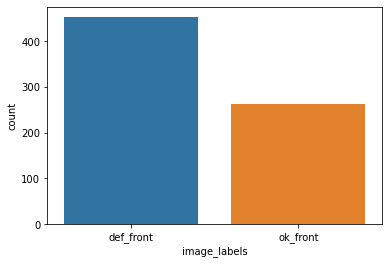

In [28]:
#Create Train Dataframe as repository of paths and labels.
valid = getdata(test_dir)
sns.countplot(valid['image_labels'])

C:\Users\Win10\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='image_labels', ylabel='count'>

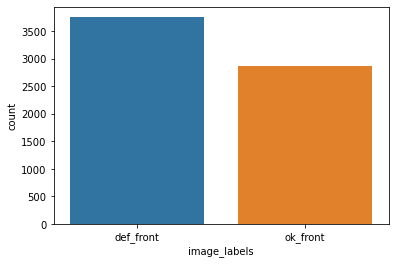

In [27]:
train_df_dir = getdata(train_dir)
sns.countplot(train_df_dir['image_labels'])

In [11]:
valid

,image_abs_path,image_labels
0,new_archive/casting_data/casting_data/test//de...,def_front
1,new_archive/casting_data/casting_data/test//de...,def_front
2,new_archive/casting_data/casting_data/test//de...,def_front
3,new_archive/casting_data/casting_data/test//de...,def_front
4,new_archive/casting_data/casting_data/test//de...,def_front
...,...,...
710,new_archive/casting_data/casting_data/test//ok...,ok_front
711,new_archive/casting_data/casting_data/test//ok...,ok_front
712,new_archive/casting_data/casting_data/test//ok...,ok_front
713,new_archive/casting_data/casting_data/test//ok...,ok_front


In [12]:
# Fetch n number of images from train data frame
def get_n_images(n,df,label):
    import warnings
    warnings.filterwarnings('ignore')
    train = df[df["image_labels"]==label]
    print(len(train))
    i = 0
    m = n/2
    plt.figure(figsize=(12, 6))
    for path in train['image_abs_path'][0:n]:
        plt.subplot(2,m,i+1)
        get_image(path)
        #plt.title(train['image_labels'][i])
        i += 1
    plt.tight_layout()
    plt.show()

In [13]:
def visualize_gen(train_generator):   
    #Visualising Images Processed
    plt.figure(figsize=(6, 3))
    for i in range(0, 10):
        plt.subplot(2, 5, i+1)
        for X_batch, Y_batch in train_generator:
            image = X_batch[0]        
            plt.axis("off")
            plt.imshow((image*255).astype(np.uint8),cmap='gray')
            break
    plt.tight_layout()
    plt.show()

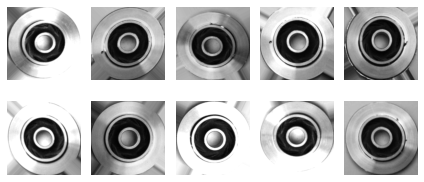

In [14]:
visualize_gen(traingen)

In [15]:
input_shape = traingen.image_shape
input_shape

(250, 250, 1)

## Build Model's Architecture

In [16]:
def imageclf2(input_shape):
    from tensorflow import keras as ks

    model = ks.models.Sequential()
    model.add(ks.layers.Conv2D(8,(3,3),
                               strides=1,
                               activation="relu",
                               padding='same',
                               name="layer1",
                               input_shape=input_shape))
    model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))
    
    model.add(ks.layers.Conv2D(8,(3,3),strides=1,padding="same",activation="relu",name="layer2"))
    model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))
    
    
    model.add(ks.layers.Flatten())
    model.add(ks.layers.Dense(128,activation="relu",
                              name="layer5"))
    model.add(ks.layers.Dense(128,activation="relu",
                              name="layer6"))
    
    model.add(ks.layers.Dense(1,activation="sigmoid",
                              name="output"))
    model.summary()
    return model

## Build the Compiler

In [17]:
def compiler2(model,train_generator,valid_generator,epchs,bsize=32,lr=0.0001):

    from tensorflow import keras as ks
    callbck = ks.callbacks.EarlyStopping(monitor='val_loss',patience=4,verbose=2,
                                         restore_best_weights=True,) 
    
    opt = ks.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss="binary_crossentropy",
                      optimizer=opt,
                      metrics=["accuracy"])
    history = model.fit(train_generator,
                        epochs=epchs,
                        callbacks=[callbck],
                        validation_data=valid_generator,
                        verbose = 1,)

    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='valid_acc')

    plt.title('lrate='+str(lr), pad=-50)
    plt.legend()
    plt.grid(True)
    return model,history

### Fit Model and Evaluate

In [18]:
model01 = imageclf2(input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Conv2D)              (None, 250, 250, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 8)       0         
_________________________________________________________________
layer2 (Conv2D)              (None, 125, 125, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 30752)             0         
_________________________________________________________________
layer5 (Dense)               (None, 128)               3936384   
_________________________________________________________________
layer6 (Dense)               (None, 128)               1

Epoch 1/50
332/332 [==============================] - 176s 527ms/step - loss: 0.5577 - accuracy: 0.7113 - val_loss: 0.4612 - val_accuracy: 0.7804
Epoch 2/50
332/332 [==============================] - 175s 526ms/step - loss: 0.4513 - accuracy: 0.7815 - val_loss: 0.3904 - val_accuracy: 0.8224
Epoch 3/50
332/332 [==============================] - 194s 583ms/step - loss: 0.3824 - accuracy: 0.8339 - val_loss: 0.3173 - val_accuracy: 0.8601
Epoch 4/50
332/332 [==============================] - 203s 610ms/step - loss: 0.3132 - accuracy: 0.8697 - val_loss: 0.2978 - val_accuracy: 0.8713
Epoch 5/50
332/332 [==============================] - 189s 568ms/step - loss: 0.2644 - accuracy: 0.8955 - val_loss: 0.2063 - val_accuracy: 0.9217
Epoch 6/50
332/332 [==============================] - 182s 547ms/step - loss: 0.2434 - accuracy: 0.9095 - val_loss: 0.2294 - val_accuracy: 0.9133
Epoch 7/50
332/332 [==============================] - 179s 538ms/step - loss: 0.2154 - accuracy: 0.9213 - val_loss: 0.1623 -

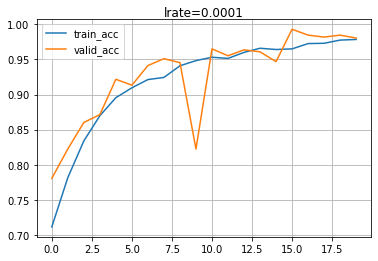

In [19]:
model_com01 = compiler2(model01,traingen,validgen,50)

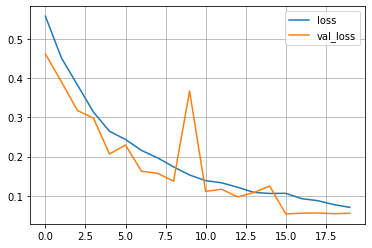

In [20]:
#Visualise loss curves
history = model_com01[1]
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [24]:
model01.save('mymodel.h5')

### Get Prediction and visualise the output.

In [70]:
def get_predictions(n):
    import keras as ks
    image1= validgen[0][0][n]
    #print(image1.shape)
    plt.imshow(image1,'gray')
    input_arr = ks.preprocessing.image.img_to_array(validgen[0][0][n])
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    predictions = model01.predict(input_arr)
    #our dictionary starts from 1 whereas model has classes from 0.
    p = predictions[0][0]*100
    p="{:.2f}".format(p)
    return  str(p)+ ' % probbility of being Okay' 

'3.02 % probbility of being Okay'

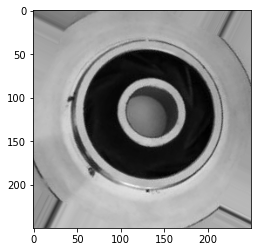

In [83]:
get_predictions(1)